# TO DO
- fai in modo che la rete impari la sua struttura in autopmatico come descritto [qui](https://pgmpy.org/examples/Structure%20Learning%20with%20Chow-Liu.html)
- train and test, come test importa il dataset di un altro anno perchè ci sono pochi sample per fare uno split
- 

# Predicting wins through players advanced statistics
<br>
    <center><img src="https://media1.giphy.com/media/XIhWoPBXHgVmU/giphy.gif?cid=ecf05e47zplee7bvey2l2qj0tn5bo4utclw4s7w8ovsgsk9v&ep=v1_gifs_search&rid=giphy.gif&ct=g"></center>
<br>
### Project carried out by [Giacomo Piergentili](https://github.com/GiacomoPiergentili) and [Francesco Cavaleri](https://github.com/CacioCavalloIsNotReal) for the Fundamentals of AI and KR course - module 3


2023_nba_player_stats.csv was downloaded [here](https://www.kaggle.com/datasets/amirhosseinmirzaie/nba-players-stats2023-season/data) and the other dataset was downloaded [here](https://www.nbastuffer.com/2022-2023-nba-player-stats/)

In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np
from pgmpy.models import BayesianNetwork


In [132]:
df1 = pd.read_csv('datasets/train/NBA_Stats_202223_All_Stats_NBA_Player_Props_Tool.csv')
df1['NAME'] = df1['NAME']\
    .replace('\'', '')\
    .replace('-', '')\
    .replace('_', '')\
    .replace('.', '')\
    .replace(' ', '')\
    .replace('"','', regex=True)\
    .str.lower()
df1 = df1.drop('RANK', axis=1)
df1.head()

,NAME,TEAM,POS,AGE,GP,MPG,USG%,TO%,FTA,FT%,...,APG,SPG,BPG,TPG,P+R,P+A,P+R+A,VI,ORtg,DRtg
0,joel embiid,Phi,C-F,29.1,66,34.6,37.0,14.5,771,0.857,...,4.2,1.0,1.7,3.4,43.2,37.2,47.4,13.0,124.4,104.1
1,luka doncic,Dal,F-G,24.1,66,36.2,37.7,14.0,694,0.742,...,8.0,1.4,0.5,3.6,41.0,40.4,49.0,14.4,120.0,109.2
2,damian lillard,Por,G,32.7,58,36.3,33.8,13.7,558,0.914,...,7.3,0.9,0.3,3.3,36.9,39.5,44.3,11.5,126.4,117.6
3,shai gilgeous-alexander,Okc,G-F,24.7,68,35.5,32.8,12.2,739,0.905,...,5.5,1.6,1.0,2.8,36.2,36.9,41.7,10.6,124.9,109.8
4,giannis antetokounmpo,Mil,F,28.3,63,32.1,38.8,16.2,772,0.645,...,5.7,0.8,0.8,3.9,42.9,36.8,48.6,15.9,116.8,100.6


In [133]:
print('the dataset columns are: ',df1.columns.values)

the dataset columns are:  ['NAME' 'TEAM' 'POS' 'AGE' 'GP' 'MPG' 'USG%' 'TO%' 'FTA' 'FT%' '2PA' '2P%'
 '3PA' '3P%' 'eFG%' 'TS%' 'PPG' 'RPG' 'APG' 'SPG' 'BPG' 'TPG' 'P+R' 'P+A'
 'P+R+A' 'VI' 'ORtg' 'DRtg']


We chose to merge this dataset with another one because we were missing some crucial variable (wins,minutes played, field goal attempts, assists, turnovers offensive rebounds, defensive rebounds)

In [134]:
df2 = pd.read_csv('datasets/train/2023_nba_player_stats.csv')
df2 = df2[['Player', 'W', 'Min', 'FGA', 'AST', 'TOV', 'OREB', 'DREB']].copy()
df2.rename(columns={'Player':'NAME'},inplace=True)
df2['NAME'] = df2['NAME'].replace(' ', '')\
    .replace('-', '')\
    .replace('_', '')\
    .replace('.', '')\
    .replace('"','', regex=True)\
    .str.lower()

df2.head()


,NAME,W,Min,FGA,AST,TOV,OREB,DREB
0,jayson tatum,52.0,2732.2,1559.0,342.0,213.0,78.0,571.0
1,joel embiid,43.0,2284.1,1328.0,274.0,226.0,113.0,557.0
2,luka doncic,33.0,2390.5,1449.0,529.0,236.0,54.0,515.0
3,shai gilgeous-alexander,33.0,2416.0,1381.0,371.0,192.0,59.0,270.0
4,giannis antetokounmpo,47.0,2023.6,1278.0,359.0,246.0,137.0,605.0


In [135]:
df3 = pd.merge(df1, df2, on='NAME')#.reset_index()

In [136]:
print('The new dataset contains ',df3.columns.values,' columns')

The new dataset contains  ['NAME' 'TEAM' 'POS' 'AGE' 'GP' 'MPG' 'USG%' 'TO%' 'FTA' 'FT%' '2PA' '2P%'
 '3PA' '3P%' 'eFG%' 'TS%' 'PPG' 'RPG' 'APG' 'SPG' 'BPG' 'TPG' 'P+R' 'P+A'
 'P+R+A' 'VI' 'ORtg' 'DRtg' 'W' 'Min' 'FGA' 'AST' 'TOV' 'OREB' 'DREB']  columns


We chose to analyze the stats of players who have played at least 41 games last season, which is half the amount of game of the Regular Season

In [137]:
df3 = df3[df3['GP']>41]#65]

df3.dropna(axis=0, inplace=True, ignore_index=True)

df3.head()

,NAME,TEAM,POS,AGE,GP,MPG,USG%,TO%,FTA,FT%,...,VI,ORtg,DRtg,W,Min,FGA,AST,TOV,OREB,DREB
0,joel embiid,Phi,C-F,29.1,66,34.6,37.0,14.5,771,0.857,...,13.0,124.4,104.1,43.0,2284.1,1328.0,274.0,226.0,113.0,557.0
1,luka doncic,Dal,F-G,24.1,66,36.2,37.7,14.0,694,0.742,...,14.4,120.0,109.2,33.0,2390.5,1449.0,529.0,236.0,54.0,515.0
2,damian lillard,Por,G,32.7,58,36.3,33.8,13.7,558,0.914,...,11.5,126.4,117.6,27.0,2106.6,1202.0,425.0,191.0,44.0,233.0
3,shai gilgeous-alexander,Okc,G-F,24.7,68,35.5,32.8,12.2,739,0.905,...,10.6,124.9,109.8,33.0,2416.0,1381.0,371.0,192.0,59.0,270.0
4,giannis antetokounmpo,Mil,F,28.3,63,32.1,38.8,16.2,772,0.645,...,15.9,116.8,100.6,47.0,2023.6,1278.0,359.0,246.0,137.0,605.0


In [138]:
df3.describe()

,AGE,GP,MPG,USG%,TO%,FTA,FT%,2PA,2P%,3PA,...,VI,ORtg,DRtg,W,Min,FGA,AST,TOV,OREB,DREB
count,322.000000,322.000000,322.000000,322.000000,322.00000,322.000000,322.000000,322.000000,322.000000,322.000000,...,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000
mean,26.714907,63.394410,24.480124,19.085093,13.39441,158.645963,0.768901,360.484472,0.548950,222.863354,...,7.515839,115.956522,109.261180,32.826087,1620.775466,596.795031,172.111801,90.453416,69.316770,220.953416
std,4.251219,11.495212,7.599011,5.809823,3.87916,139.396559,0.097484,250.595754,0.067977,160.396918,...,2.021111,9.119848,4.331557,10.157369,623.597327,344.765243,136.960485,56.628312,55.780156,130.754679
min,19.400000,42.000000,8.300000,6.500000,5.60000,4.000000,0.357000,15.000000,0.367000,0.000000,...,3.500000,88.300000,93.200000,7.000000,347.600000,89.000000,9.000000,10.000000,5.000000,36.000000
25%,23.500000,54.000000,18.700000,14.725000,10.60000,60.000000,0.723000,168.500000,0.503250,108.250000,...,6.100000,109.600000,106.125000,26.000000,1090.350000,318.250000,69.000000,45.000000,31.250000,130.250000
50%,26.100000,64.000000,24.900000,17.800000,13.00000,119.500000,0.778500,299.500000,0.544000,202.000000,...,7.200000,115.600000,109.400000,33.000000,1677.300000,522.000000,126.000000,79.000000,52.500000,189.500000
75%,29.675000,74.000000,31.000000,22.150000,15.60000,204.500000,0.841000,502.500000,0.588000,324.750000,...,8.600000,120.775000,112.000000,40.000000,2129.375000,831.750000,243.750000,121.750000,87.000000,280.500000
max,38.300000,82.000000,37.400000,38.800000,30.10000,772.000000,0.934000,1213.000000,0.783000,731.000000,...,16.800000,148.700000,122.200000,57.000000,2963.200000,1559.000000,741.000000,300.000000,274.000000,744.000000


In [139]:
# da levare
if len(df3.count().unique()) == 1:
    print('The dataset does not contains missing values')
else:
    print('The dataset does contains missing values')
if df3.isna().sum().sum() == 0:
    print('the dataset does not contains Nan')

The dataset does not contains missing values
the dataset does not contains Nan


We modify the dataset leaving only the needed columns

In [140]:
df3 = df3[['NAME', 'AGE', 'GP', 'USG%', 'FTA', 'TO%', 'eFG%', 'APG', 'TPG', 'ORtg', 'DRtg', 'W', 'Min', 'FGA', 'AST', 'TOV', 'OREB', 'DREB']].copy()
df3.head()

,NAME,AGE,GP,USG%,FTA,TO%,eFG%,APG,TPG,ORtg,DRtg,W,Min,FGA,AST,TOV,OREB,DREB
0,joel embiid,29.1,66,37.0,771,14.5,0.573,4.2,3.4,124.4,104.1,43.0,2284.1,1328.0,274.0,226.0,113.0,557.0
1,luka doncic,24.1,66,37.7,694,14.0,0.560,8.0,3.6,120.0,109.2,33.0,2390.5,1449.0,529.0,236.0,54.0,515.0
2,damian lillard,32.7,58,33.8,558,13.7,0.564,7.3,3.3,126.4,117.6,27.0,2106.6,1202.0,425.0,191.0,44.0,233.0
3,shai gilgeous-alexander,24.7,68,32.8,739,12.2,0.531,5.5,2.8,124.9,109.8,33.0,2416.0,1381.0,371.0,192.0,59.0,270.0
4,giannis antetokounmpo,28.3,63,38.8,772,16.2,0.571,5.7,3.9,116.8,100.6,47.0,2023.6,1278.0,359.0,246.0,137.0,605.0


In [141]:
df3.describe()

,AGE,GP,USG%,FTA,TO%,eFG%,APG,TPG,ORtg,DRtg,W,Min,FGA,AST,TOV,OREB,DREB
count,322.000000,322.000000,322.000000,322.000000,322.00000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000
mean,26.714907,63.394410,19.085093,158.645963,13.39441,0.549627,2.616460,1.376708,115.956522,109.261180,32.826087,1620.775466,596.795031,172.111801,90.453416,69.316770,220.953416
std,4.251219,11.495212,5.809823,139.396559,3.87916,0.054711,2.028429,0.814578,9.119848,4.331557,10.157369,623.597327,344.765243,136.960485,56.628312,55.780156,130.754679
min,19.400000,42.000000,6.500000,4.000000,5.60000,0.405000,0.200000,0.200000,88.300000,93.200000,7.000000,347.600000,89.000000,9.000000,10.000000,5.000000,36.000000
25%,23.500000,54.000000,14.725000,60.000000,10.60000,0.515000,1.100000,0.800000,109.600000,106.125000,26.000000,1090.350000,318.250000,69.000000,45.000000,31.250000,130.250000
50%,26.100000,64.000000,17.800000,119.500000,13.00000,0.550500,1.900000,1.150000,115.600000,109.400000,33.000000,1677.300000,522.000000,126.000000,79.000000,52.500000,189.500000
75%,29.675000,74.000000,22.150000,204.500000,15.60000,0.575000,3.575000,1.800000,120.775000,112.000000,40.000000,2129.375000,831.750000,243.750000,121.750000,87.000000,280.500000
max,38.300000,82.000000,38.800000,772.000000,30.10000,0.776000,10.700000,4.100000,148.700000,122.200000,57.000000,2963.200000,1559.000000,741.000000,300.000000,274.000000,744.000000


We are still missing some stats:
1. FTA_RATE = FTA / FGA
2. AST_RATIO = 100 * AST / (AST + FGA + 0.44*FTA + TO)
3. WIN% = WIN / GP
4. OREBPG = OREB / GP
5. DREBPG = DREB / GP

In [142]:
df3['FTA_RATE'] = df3['FTA'] / df3['FGA']
df3['AST_RATIO'] = 100 * df3['FTA'] / (df3['AST'] + df3['FGA']+ 0.44 * df3['FTA'] + df3['TOV'])
df3['WIN%'] = df3['W'] / df3['GP']
df3['OREBPG'] = df3['OREB'] / df3['GP']
df3['DREBPG'] = df3['DREB'] / df3['GP']
#df3.head()


Now that we have all the variables we need, we rearrange the dataset in a more readable way

In [143]:
df_final = df3[['NAME', 'AGE', 'APG', 'AST_RATIO', 'eFG%', 'FTA_RATE', 'DRtg', 'DREBPG', 'Min', 'TO%', 'OREBPG', 'ORtg', 'USG%', 'WIN%']].copy()
df_final.reset_index(inplace=True, drop=True)



df_final.head()


,NAME,AGE,APG,AST_RATIO,eFG%,FTA_RATE,DRtg,DREBPG,Min,TO%,OREBPG,ORtg,USG%,WIN%
0,joel embiid,29.1,4.2,35.575202,0.573,0.580572,104.1,8.439394,2284.1,14.5,1.712121,124.4,37.0,0.651515
1,luka doncic,24.1,8.0,27.546679,0.560,0.478951,109.2,7.803030,2390.5,14.0,0.818182,120.0,37.7,0.500000
2,damian lillard,32.7,7.3,27.041172,0.564,0.464226,117.6,4.017241,2106.6,13.7,0.758621,126.4,33.8,0.465517
3,shai gilgeous-alexander,24.7,5.5,32.567117,0.531,0.535119,109.8,3.970588,2416.0,12.2,0.867647,124.9,32.8,0.485294
4,giannis antetokounmpo,28.3,5.7,34.732845,0.571,0.604069,100.6,9.603175,2023.6,16.2,2.174603,116.8,38.8,0.746032


In [144]:
df_final.describe()

,AGE,APG,AST_RATIO,eFG%,FTA_RATE,DRtg,DREBPG,Min,TO%,OREBPG,ORtg,USG%,WIN%
count,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.00000,322.000000,322.000000,322.000000,322.000000
mean,26.714907,2.616460,16.214807,0.549627,0.253435,109.261180,3.425260,1620.775466,13.39441,1.076449,115.956522,19.085093,0.517060
std,4.251219,2.028429,7.383532,0.054711,0.121958,4.331557,1.853488,623.597327,3.87916,0.842854,9.119848,5.809823,0.130354
min,19.400000,0.200000,1.445296,0.405000,0.030534,93.200000,0.578125,347.600000,5.60000,0.096154,88.300000,6.500000,0.166667
25%,23.500000,1.100000,10.413587,0.515000,0.155172,106.125000,2.133654,1090.350000,10.60000,0.513341,109.600000,14.725000,0.453814
50%,26.100000,1.900000,15.282208,0.550500,0.233388,109.400000,2.964640,1677.300000,13.00000,0.816058,115.600000,17.800000,0.521127
75%,29.675000,3.575000,20.986307,0.575000,0.325493,112.000000,4.165625,2129.375000,15.60000,1.322890,120.775000,22.150000,0.595850
max,38.300000,10.700000,37.585673,0.776000,0.625000,122.200000,9.603175,2963.200000,30.10000,5.130435,148.700000,38.800000,0.857143


In [145]:
if len(df_final.count().unique()) == 1:
    print('The dataset does not contains missing values')
else:
    print('The dataset does contains missing values')
if df_final.isna().sum().sum() == 0:
    print('the dataset does not contains Nan')

The dataset does not contains missing values
the dataset does not contains Nan


In [146]:
len(df_final['AGE'])

322

Discretizing continuos variables

In [147]:
from feature_engine.discretisation import EqualWidthDiscretiser

bins = 4
widthDiscretiser=EqualWidthDiscretiser(bins=bins)
widthDiscretiser.fit(df_final)
#widthDiscretiser.binner_dict_

EqualWidthDiscretiser(bins=4)

In [148]:
df_final.describe()

,AGE,APG,AST_RATIO,eFG%,FTA_RATE,DRtg,DREBPG,Min,TO%,OREBPG,ORtg,USG%,WIN%
count,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.00000,322.000000,322.000000,322.000000,322.000000
mean,26.714907,2.616460,16.214807,0.549627,0.253435,109.261180,3.425260,1620.775466,13.39441,1.076449,115.956522,19.085093,0.517060
std,4.251219,2.028429,7.383532,0.054711,0.121958,4.331557,1.853488,623.597327,3.87916,0.842854,9.119848,5.809823,0.130354
min,19.400000,0.200000,1.445296,0.405000,0.030534,93.200000,0.578125,347.600000,5.60000,0.096154,88.300000,6.500000,0.166667
25%,23.500000,1.100000,10.413587,0.515000,0.155172,106.125000,2.133654,1090.350000,10.60000,0.513341,109.600000,14.725000,0.453814
50%,26.100000,1.900000,15.282208,0.550500,0.233388,109.400000,2.964640,1677.300000,13.00000,0.816058,115.600000,17.800000,0.521127
75%,29.675000,3.575000,20.986307,0.575000,0.325493,112.000000,4.165625,2129.375000,15.60000,1.322890,120.775000,22.150000,0.595850
max,38.300000,10.700000,37.585673,0.776000,0.625000,122.200000,9.603175,2963.200000,30.10000,5.130435,148.700000,38.800000,0.857143


Text(0, 0.5, 'Numbers')

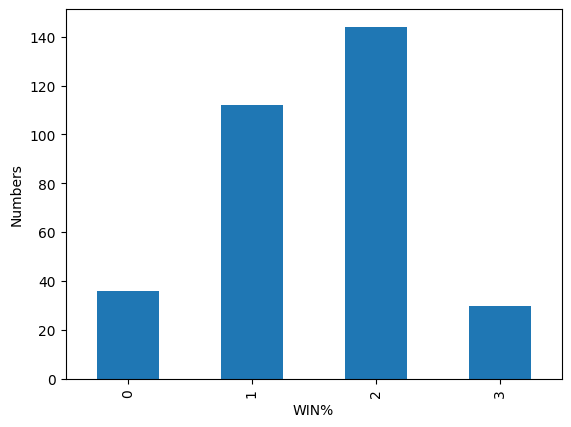

In [149]:
df=widthDiscretiser.transform(df_final)

whatToPlot='WIN%'
df.groupby(whatToPlot)[whatToPlot].count().plot.bar()
plt.ylabel('Numbers')

In [150]:
df.describe()

,AGE,APG,AST_RATIO,eFG%,FTA_RATE,DRtg,DREBPG,Min,TO%,OREBPG,ORtg,USG%,WIN%
count,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000
mean,1.062112,0.478261,1.127329,1.037267,0.981366,1.726708,0.736025,1.440994,0.770186,0.316770,1.322981,1.059006,1.521739
std,0.925172,0.736980,0.867875,0.640173,0.838869,0.669659,0.847503,0.997472,0.681289,0.625744,0.670727,0.777164,0.813339
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.250000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
50%,1.000000,0.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,0.000000,1.000000,1.000000,2.000000
75%,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,0.000000,2.000000,1.000000,2.000000
max,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000


This is the final dataset we are going to use

In [151]:
df.head()

,NAME,AGE,APG,AST_RATIO,eFG%,FTA_RATE,DRtg,DREBPG,Min,TO%,OREBPG,ORtg,USG%,WIN%
0,joel embiid,2,1,3,1,3,1,3,2,1,1,2,3,2
1,luka doncic,0,2,2,1,3,2,3,3,1,0,2,3,1
2,damian lillard,2,2,2,1,2,3,1,2,1,0,2,3,1
3,shai gilgeous-alexander,1,2,3,1,3,2,1,3,1,0,2,3,1
4,giannis antetokounmpo,1,2,3,1,3,1,3,2,1,1,1,3,3


array([[<Axes: title={'center': 'AGE'}>, <Axes: title={'center': 'APG'}>,
        <Axes: title={'center': 'AST_RATIO'}>,
        <Axes: title={'center': 'eFG%'}>],
       [<Axes: title={'center': 'FTA_RATE'}>,
        <Axes: title={'center': 'DRtg'}>,
        <Axes: title={'center': 'DREBPG'}>,
        <Axes: title={'center': 'Min'}>],
       [<Axes: title={'center': 'TO%'}>,
        <Axes: title={'center': 'OREBPG'}>,
        <Axes: title={'center': 'ORtg'}>,
        <Axes: title={'center': 'USG%'}>],
       [<Axes: title={'center': 'WIN%'}>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

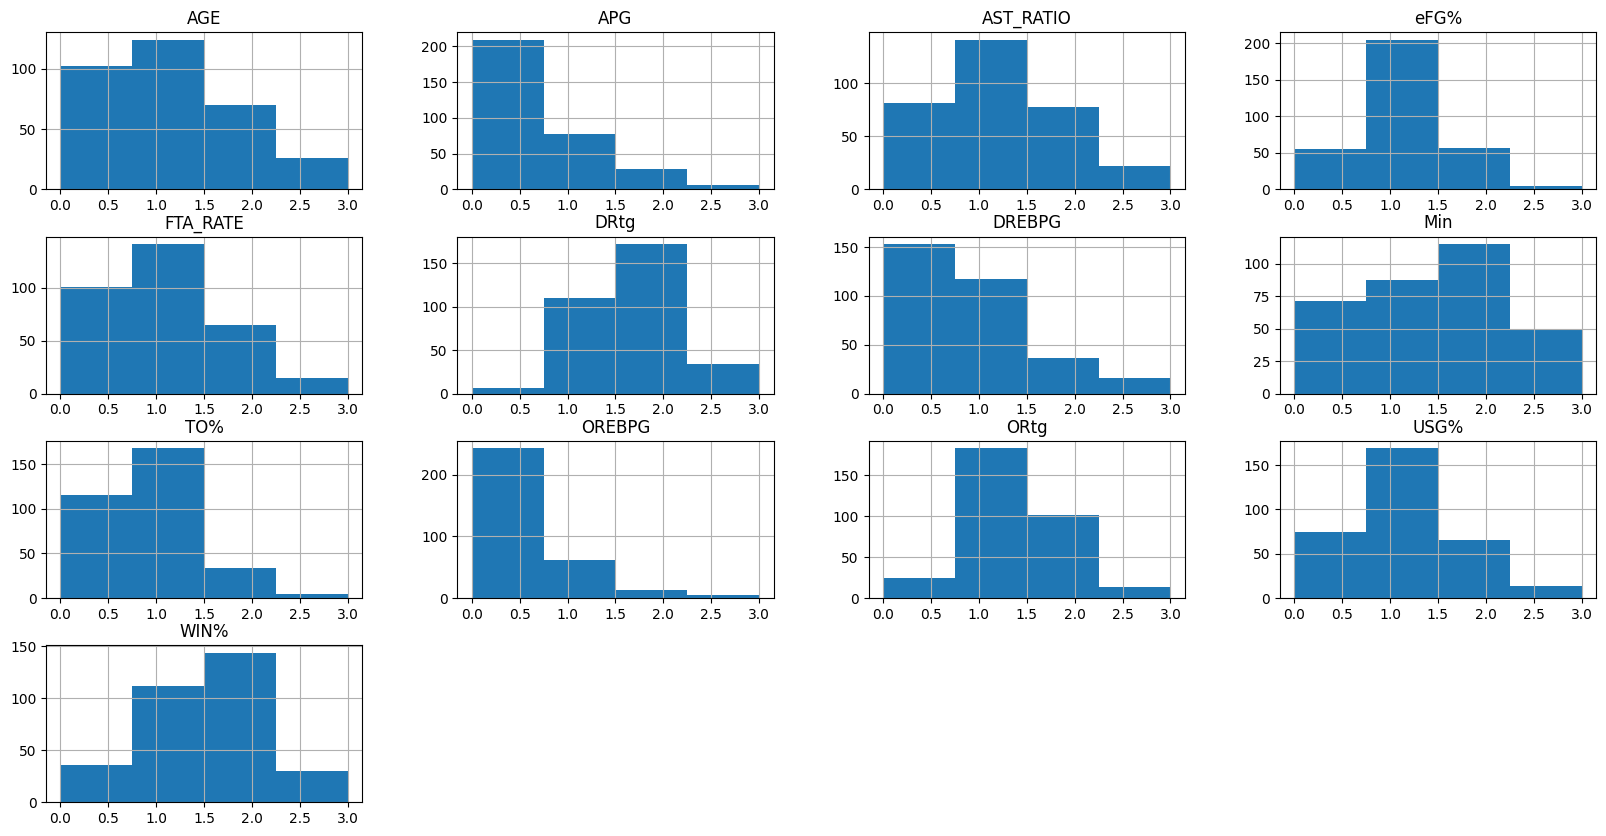

In [152]:
df.hist(bins=bins, figsize=(20,10))

Text(0.5, 1.0, 'Model')

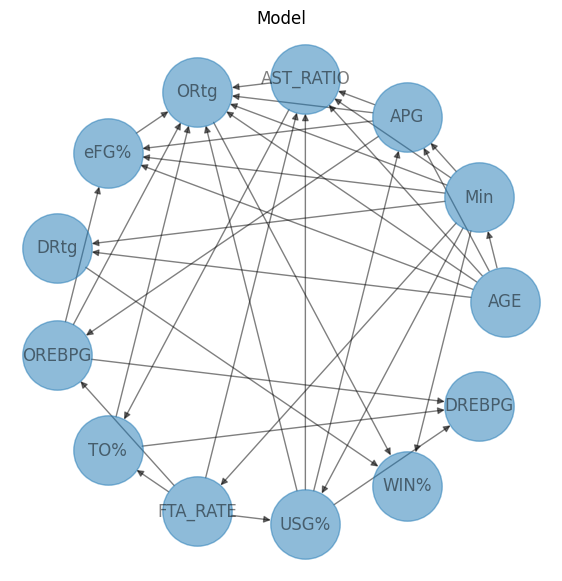

In [173]:
custom_model = BayesianNetwork([('AGE', 'Min'), ('AGE', 'APG'),
                                ('AGE', 'AST_RATIO'), ('AGE', 'ORtg'),
                                ('AGE', 'eFG%'), ('AGE', 'DRtg'),
                                ('APG', 'AST_RATIO'), ('APG', 'OREBPG'),
                                ('APG', 'ORtg'), ('APG', 'eFG%'),
                                ('AST_RATIO', 'ORtg'), ('AST_RATIO', 'TO%'),
                                ('eFG%', 'ORtg'),
                                ('FTA_RATE', 'AST_RATIO'), ('FTA_RATE', 'OREBPG'),
                                ('FTA_RATE', 'TO%'), ('FTA_RATE', 'USG%'),
                                ('DRtg', 'WIN%'),
                                ('Min', 'FTA_RATE'), ('Min', 'APG'),
                                ('Min', 'AST_RATIO'), ('Min', 'USG%'),
                                ('Min', 'ORtg'), ('Min', 'eFG%'),
                                ('Min', 'WIN%'), ('Min', 'DRtg'),
                                ('TO%', 'DREBPG'), ('TO%', 'ORtg'),
                                ('OREBPG', 'eFG%'), ('OREBPG', 'ORtg'),
                                ('OREBPG', 'DREBPG'),
                                ('ORtg', 'WIN%'),
                                ('USG%', 'APG'), ('USG%', 'AST_RATIO'),
                                ('USG%', 'DREBPG'), ('USG%', 'ORtg')])
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
nx.draw_circular(custom_model, with_labels=True, node_size=2500, alpha=0.5, ax=ax)
ax.set_title('Model')


In [154]:
# Da rimuovere
pipo=np.array([('AGE', 'Min'), ('AGE', 'APG'),
                                ('AGE', 'AST_RATIO'), ('AGE', 'ORtg'),
                                ('AGE', 'EFG%'), ('AGE', 'DRtg'),
                                ('APG', 'AST_RATIO'), ('APG', 'OREBPG'),
                                ('APG', 'ORtg'), ('APG', 'eFG%'),
                                ('AST_RATIO', 'ORtg'), ('AST_RATIO', 'TO%'),
                                ('eFG%', 'ORtg'),
                                ('FTA_RATE', 'AST_RATIO'), ('FTA_RATE', 'OREBPG'),
                                ('FTA_RATE', 'TO%'), ('FTA_RATE', 'USG%'),
                                ('DRtg', 'WIN%'),
                                ('Min', 'FTA_RATE'), ('Min', 'APG'),
                                ('Min', 'AST_RATIO'), ('Min', 'USG%'),
                                ('Min', 'ORtg'), ('Min', 'eFG%'),
                                ('Min', 'WIN%'), ('Min', 'DRtg'),
                                ('TO%', 'DREBPG'), ('TO%', 'ORtg'),
                                ('OREBPG', 'eFG%'), ('OREBPG', 'ORtg'),
                                ('OREBPG', 'DREBPG'),
                                ('ORtg', 'WIN%'),
                                ('USG%', 'APG'), ('USG%', 'AST_RATIO'),
                                ('USG%', 'DREBPG'), ('USG%', 'ORtg')])
print((
    df.drop('NAME', axis=1).columns.values
    ))
print((
    np.unique(pipo)
    ))

['AGE' 'APG' 'AST_RATIO' 'eFG%' 'FTA_RATE' 'DRtg' 'DREBPG' 'Min' 'TO%'
 'OREBPG' 'ORtg' 'USG%' 'WIN%']
['AGE' 'APG' 'AST_RATIO' 'DREBPG' 'DRtg' 'EFG%' 'FTA_RATE' 'Min' 'OREBPG'
 'ORtg' 'TO%' 'USG%' 'WIN%' 'eFG%']


In [155]:
custom_model.fit(df, n_jobs=6)

In [156]:
cpds = custom_model.get_cpds()
if not custom_model.check_model():
    print('The model has errors.')
else:
    print('The model has no errors.')

The model has no errors.


In [157]:

from pgmpy.inference import VariableElimination
nb_inference = VariableElimination(custom_model)

In [158]:
pipo=df.drop('WIN%', axis=1).to_dict().keys()
pipo

dict_keys(['NAME', 'AGE', 'APG', 'AST_RATIO', 'eFG%', 'FTA_RATE', 'DRtg', 'DREBPG', 'Min', 'TO%', 'OREBPG', 'ORtg', 'USG%'])

In [159]:
campione = 0

In [160]:
#df.drop('WIN%', axis=1).iloc[campione].to_dict()

In [161]:
result = nb_inference.query(
            variables=['WIN%'],
            evidence=df.drop('WIN%', axis=1).drop('NAME', axis=1).iloc[campione].to_dict(),
            show_progress=False,
        )

In [162]:
np.argmax(result.values)

2

In [163]:
df.iloc[campione].to_dict()['WIN%']

2

In [164]:
df.shape[0]

322

In [165]:
my_results={}
my_results['estimated']=[]
for i in range(df.shape[0]):
    result = nb_inference.query(
            variables=['WIN%'],
            evidence=df.drop('WIN%', axis=1).drop('NAME', axis=1).iloc[i].to_dict(),
            show_progress=False,
        )
    my_results['estimated'].append(np.argmax(result.values))
    

In [166]:
from sklearn.metrics import accuracy_score
accuracy_score(df['WIN%'].values,my_results['estimated'])

0.562111801242236

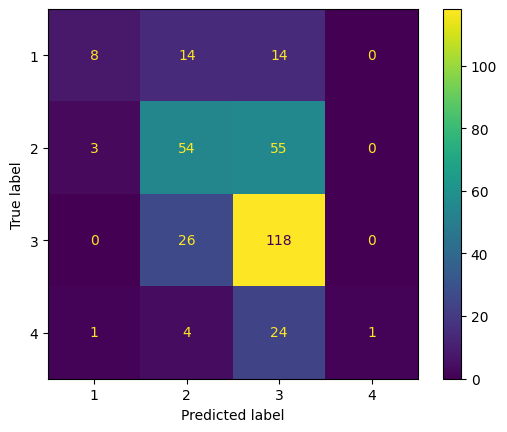

In [167]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(df['WIN%'].values,my_results['estimated'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=range(1,bins+1))
disp.plot()
plt.show()

We can try to learn the structure of the network using the Chow-Liu algorithm as descripter [here](https://pgmpy.org/examples/Structure%20Learning%20with%20Chow-Liu.html)

generate sample data from our tree Bayesian network

In [168]:
from pgmpy.sampling import BayesianModelSampling

# sample data from BN
inference = BayesianModelSampling(custom_model)
df_data = inference.forward_sample(size=10000)
print(df_data)

Generating for node: WIN%: 100%|██████████| 13/13 [00:00<00:00, 87.32it/s] 

      AGE  Min  APG  AST_RATIO  ORtg  eFG%  DRtg  OREBPG  TO%  FTA_RATE  USG%  \
0       2    1    0          2     1     1     2       1    1         2     1   
1       2    2    0          1     1     1     2       0    0         1     2   
2       0    0    0          2     3     2     2       1    2         2     1   
3       1    0    0          1     2     1     1       0    1         1     1   
4       1    0    1          0     2     1     1       0    3         1     2   
...   ...  ...  ...        ...   ...   ...   ...     ...  ...       ...   ...   
9995    0    2    3          2     1     1     2       0    1         2     3   
9996    1    1    0          1     3     2     2       1    0         1     1   
9997    2    2    0          1     1     1     3       0    0         0     1   
9998    3    2    2          0     3     1     2       0    0         0     1   
9999    1    3    2          2     2     1     1       0    2         2     2   

      WIN%  DREBPG  
0     


/home/francesco/.local/lib/python3.10/site-packages/pgmpy/sampling/base.py:582: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)


apply the Chow-Liu algorithm to learn the tree graph from sample data

Building tree: 100%|██████████| 78/78.0 [00:00<00:00, 2707.95it/s]


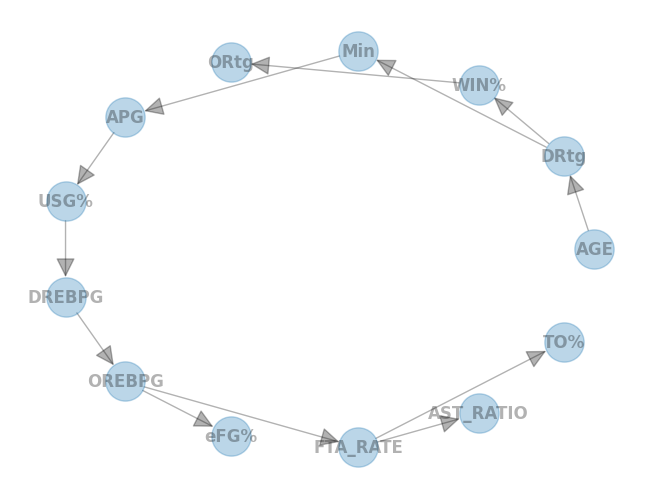

In [169]:
from pgmpy.estimators import TreeSearch

# learn graph structure
est = TreeSearch(df_data, root_node="AGE")
dag = est.estimate(estimator_type="chow-liu")
nx.draw_circular(
    dag, with_labels=True, arrowsize=30, node_size=800, alpha=0.3, font_weight="bold"
)
plt.show()

In [170]:
# imbarazzante tentativo di stimare la rete
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BDeuScore, K2Score, BicScore

numeric_df=df.drop('NAME',axis=1)
hc = HillClimbSearch(numeric_df, use_cache=True)
best_est_model={0:{'estimator':BDeuScore},
                1:{'estimator':K2Score},
                2:{'estimator':BicScore}}

for i in range(3):
       print('\nestimating using the ', best_est_model[i]['estimator'].__name__, 'estimator')
       best_est_model[i]['DAG'] = hc.estimate(scoring_method=best_est_model[i]['estimator'](numeric_df))
       print(best_est_model[i]['DAG'].edges())



estimating using the  BDeuScore estimator


  0%|          | 12/1000000 [00:00<12:51:12, 21.61it/s]


[('APG', 'USG%'), ('eFG%', 'ORtg'), ('FTA_RATE', 'AST_RATIO'), ('FTA_RATE', 'TO%'), ('DRtg', 'WIN%'), ('DREBPG', 'Min'), ('Min', 'APG'), ('OREBPG', 'DREBPG'), ('OREBPG', 'FTA_RATE'), ('OREBPG', 'DRtg'), ('ORtg', 'OREBPG'), ('WIN%', 'AGE')]

estimating using the  K2Score estimator


  0%|          | 73/1000000 [00:01<5:47:01, 48.02it/s]


[('AGE', 'DREBPG'), ('AGE', 'FTA_RATE'), ('AGE', 'AST_RATIO'), ('AGE', 'Min'), ('AGE', 'TO%'), ('AGE', 'WIN%'), ('AGE', 'USG%'), ('APG', 'USG%'), ('APG', 'DREBPG'), ('APG', 'Min'), ('APG', 'FTA_RATE'), ('APG', 'AST_RATIO'), ('APG', 'TO%'), ('APG', 'WIN%'), ('AST_RATIO', 'DREBPG'), ('AST_RATIO', 'FTA_RATE'), ('AST_RATIO', 'Min'), ('eFG%', 'ORtg'), ('eFG%', 'DREBPG'), ('eFG%', 'FTA_RATE'), ('eFG%', 'AST_RATIO'), ('eFG%', 'Min'), ('eFG%', 'TO%'), ('eFG%', 'WIN%'), ('eFG%', 'USG%'), ('FTA_RATE', 'DREBPG'), ('FTA_RATE', 'Min'), ('DRtg', 'DREBPG'), ('DRtg', 'FTA_RATE'), ('DRtg', 'AST_RATIO'), ('DRtg', 'WIN%'), ('DRtg', 'Min'), ('DRtg', 'TO%'), ('DRtg', 'USG%'), ('Min', 'DREBPG'), ('TO%', 'DREBPG'), ('TO%', 'FTA_RATE'), ('TO%', 'AST_RATIO'), ('TO%', 'Min'), ('TO%', 'WIN%'), ('TO%', 'USG%'), ('OREBPG', 'DREBPG'), ('OREBPG', 'FTA_RATE'), ('OREBPG', 'AST_RATIO'), ('OREBPG', 'eFG%'), ('OREBPG', 'DRtg'), ('OREBPG', 'Min'), ('OREBPG', 'TO%'), ('OREBPG', 'WIN%'), ('OREBPG', 'USG%'), ('ORtg', 'DREBPG

  0%|          | 8/1000000 [00:00<15:09:36, 18.32it/s]

[('FTA_RATE', 'AST_RATIO'), ('DREBPG', 'Min'), ('DREBPG', 'OREBPG'), ('Min', 'USG%'), ('OREBPG', 'ORtg'), ('OREBPG', 'FTA_RATE'), ('ORtg', 'eFG%'), ('USG%', 'APG')]


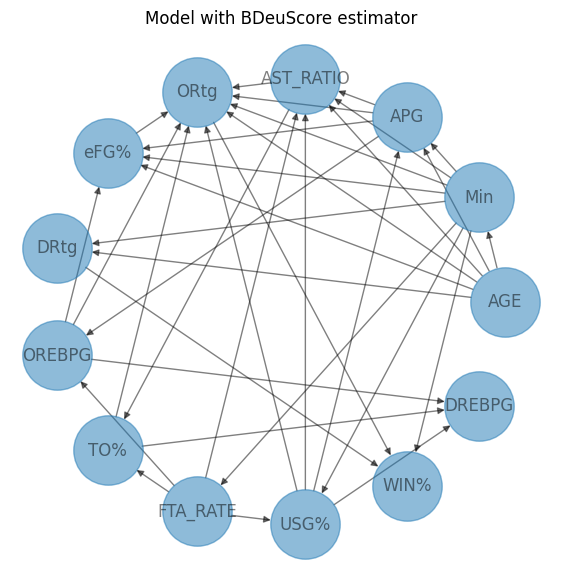

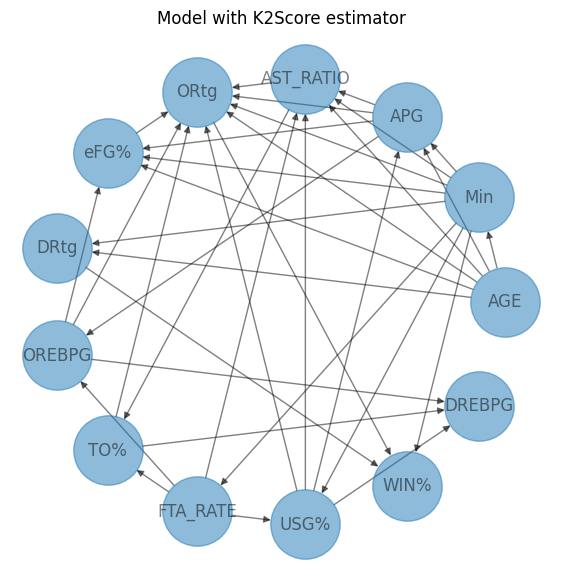

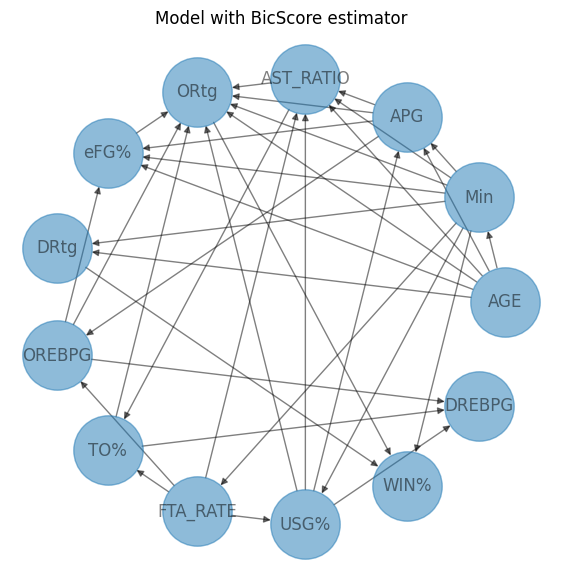

In [171]:
for i in range(3):
    best_est_model[i]['model']=BayesianNetwork(best_est_model[i]['DAG'])
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    nx.draw_circular(custom_model, with_labels=True, node_size=2500, alpha=0.5, ax=ax)
    ax.set_title('Model with ' + best_est_model[i]['estimator'].__name__ + ' estimator')
